In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./..")

In [3]:
# third party libraries
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path

# default libraries
import datetime
import time

# local imports
from effcn.models import SmallNorbEcnBackbone, SmallNorbEcnDecoder, SmallNorbEffCapsNet, SmallNorbEffCapsNetYMask
from effcn.layers import PrimaryCaps, FCCaps
from effcn.functions import margin_loss, max_norm_masking, masking_max_norm, masking_y_true
from smallnorb.smallnorb import SmallNORB
from effcn.utils import count_parameters

In [4]:
#  using params from paper
BATCH_SIZE = 16
NUM_EPOCHS = 150
LEARNING_RATE = 5e-4 * 2**0
SCHEDULER_GAMMA = 0.97
REC_LOSS_WEIGHT = 0.392
NUM_WORKERS = 6

In [5]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
DEVICE = torch.device(dev)

In [6]:
print(DEVICE)

cpu


In [26]:
transform_train = T.Compose([
    T.Resize(64),
    T.RandomCrop(48),
    T.ToTensor()
])
transform_valid = T.Compose([
    T.Resize(64),
    T.RandomCrop(48),
    T.ToTensor()
])

In [27]:
ds_train = SmallNORB(root='data/SmallNORB',train=True, download=True, transform=transform_train, mode="nopil")
ds_valid = SmallNORB(root='data/SmallNORB',train=False, download=True, transform=transform_valid, mode="nopil")


#
dl_train = torch.utils.data.DataLoader(ds_train, 
                                       batch_size=16, 
                                       shuffle=True, 
                                       num_workers=4)
dl_valid = torch.utils.data.DataLoader(ds_valid, 
                                       batch_size=16, 
                                       shuffle=True, 
                                       num_workers=4)

In [9]:
ds_train[0][0].size()

torch.Size([2, 48, 48])

In [10]:
ds_valid[0][0].size()

torch.Size([2, 48, 48])

In [23]:
# plot train imgs
x, y, z = next(iter(dl_train))

x[:64,:1,:,:].size()
x[:64,1:2,:,:].size()


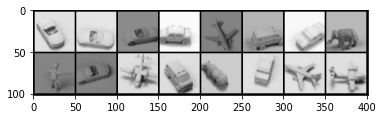

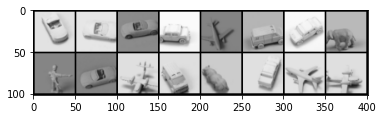

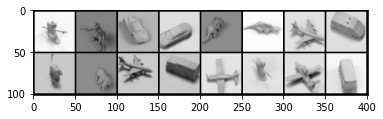

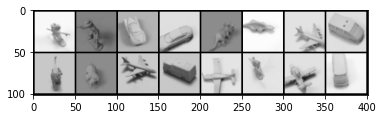

In [28]:
# plot train imgs
x, y, z = next(iter(dl_train))

# stereo channel 1
img = torchvision.utils.make_grid(x[:64,:1,:,:], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

# stereo channel 2
img = torchvision.utils.make_grid(x[:64,1:2,:,:], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

# plot valid imgs
x, y, z = next(iter(dl_valid))

# stereo channel 1
img = torchvision.utils.make_grid(x[:64,:1,:,:], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

# stereo channel 2
img = torchvision.utils.make_grid(x[:64,1:2,:,:], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

## Train Model

In [12]:
model = SmallNorbEffCapsNet()
model = model.to(DEVICE)

In [13]:
optimizer = optim.Adam(model.parameters(), lr = 5e-4)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

In [14]:
# training statistics
stats = {
    'acc_train': [],
    'acc_valid': [],
}

In [15]:
# print stuff
print("#" * 100)
print("#params:            {:,}".format(count_parameters(model)))
print("Using device:       {}".format(DEVICE))
print("Learning rate:      {}".format(LEARNING_RATE))
print("Batch size:         {}".format(BATCH_SIZE))
#print("Writing results to: {}".format(p_run))
print("#" * 100)

####################################################################################################
#params:            380,658
Using device:       cpu
Learning rate:      0.0005
Batch size:         16
####################################################################################################


In [16]:
epoch_loss = 0
epoch_correct = 0

num_epochs = 1
#
for epoch_idx in range(1, num_epochs +1):
    # ####################
    # TRAIN
    # ####################
    model.train()
    epoch_correct = 0
    epoch_total = 0
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x, y_true, _ in pbar:
        x = x.to(DEVICE)
        y_true = y_true.to(DEVICE)

        #optimizer.zero_grad()

        # way faster than optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None
        
        u_h, x_rec = model.forward(x)
        
        # LOSS
        y_one_hot = F.one_hot(y_true, num_classes=5)
        loss_margin = margin_loss(u_h, y_one_hot)
        loss_rec = torch.nn.functional.mse_loss(x, x_rec)
        loss_rec = REC_LOSS_WEIGHT * loss_rec
        
        #Total Loss
        loss = loss_margin + loss_rec
        loss.backward()
        
        optimizer.step()
        
        # validate batch
        y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
        
        correct = (y_true == y_pred).sum()
        acc = correct / y_true.shape[0]
        
        epoch_correct += correct.item()
        epoch_loss += loss.item()
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'mar': loss_margin.item(),
                 'rec': loss_rec.item(),
                 'acc': acc.item()
                 }
        )
        break
    break
    
    
    lr_scheduler.step()
    # ####################
    # VALID
    # ####################
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true, _ in dl_valid:
        x = x.to(DEVICE)
        y_true = y_true.to(DEVICE)
        
        with torch.no_grad():
            #u_l = model.primcaps(model.backbone(x))
            #u_h = model.fcncaps(u_l)
            u_h, x_rec = model.forward(x)            
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   acc_valid: {:.3f}".format(total_correct / total))

Train [  1/  1]:          | 0/1519 [00:02<?, ?it/s, loss=0.468, mar=0.428, rec=0.0401, acc=0.188]                          


### loss rec argmax & y

In [13]:
model = SmallNorbEffCapsNetYMask()
model = model.to(DEVICE)

In [14]:
optimizer = optim.Adam(model.parameters(), lr = 5e-4)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

In [15]:
# print stuff
print("#" * 100)
print("#params:            {:,}".format(count_parameters(model)))
print("Using device:       {}".format(DEVICE))
print("Learning rate:      {}".format(LEARNING_RATE))
print("Batch size:         {}".format(BATCH_SIZE))
#print("Writing results to: {}".format(p_run))
print("#" * 100)

####################################################################################################
#params:            380,658
Using device:       cpu
Learning rate:      0.0005
Batch size:         16
####################################################################################################


In [16]:

num_epochs = 1
#
for epoch_idx in range(1, num_epochs +1):
    # ####################
    # TRAIN
    # ####################
    model.train()
    epoch_correct = 0
    epoch_total = 0
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x, y_true, _ in pbar:
        x = x.to(DEVICE)
        y_true = y_true.to(DEVICE)

        #optimizer.zero_grad()

        # way faster than optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None
        
        u_h, x_rec_max, x_rec_y = model.forward(x, y_true)
        
        print("x_rec_max: ", x_rec_max.size())
        print("x_rec_y: ", x_rec_y.size())
        
        # LOSS
        y_one_hot = F.one_hot(y_true, num_classes=5)
        loss_margin = margin_loss(u_h, y_one_hot)
        loss_rec = torch.nn.functional.mse_loss(x, x_rec_y)
        loss_rec = REC_LOSS_WEIGHT * loss_rec
        
        #Total Loss
        loss = loss_margin + loss_rec
        loss.backward()
        
        optimizer.step()
        
        # validate batch
        y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
        print(y_pred)
        print(y_true)
        print(y_true - y_pred)
        
        correct = (y_true == y_pred).sum()
        acc = correct / y_true.shape[0]
        
        epoch_correct += correct.item()
        epoch_loss += loss.item()
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'mar': loss_margin.item(),
                 'rec': loss_rec.item(),
                 'acc': acc.item()
                 }
        )
        break
    break    
    
    lr_scheduler.step()
    # ####################
    # VALID
    # ####################
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true, _ in dl_valid:
        x = x.to(DEVICE)
        y_true = y_true.to(DEVICE)
        
        with torch.no_grad():
            #u_l = model.primcaps(model.backbone(x))
            #u_h = model.fcncaps(u_l)
            u_h, x_rec_max, x_rec_y  = model.forward(x, y_true)            
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   acc_valid: {:.3f}".format(total_correct / total))

Train [  1/  1]:          | 0/1519 [00:00<?, ?it/s]                                                                    

x_rec_max:  torch.Size([16, 2, 48, 48])
x_rec_y:  torch.Size([16, 2, 48, 48])
tensor([4, 1, 4, 1, 3, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1])
tensor([4, 3, 1, 2, 2, 0, 3, 1, 0, 3, 1, 4, 1, 0, 3, 4])
tensor([ 0,  2, -3,  1, -1, -4, -1,  0, -1,  2,  0,  0,  0, -1,  2,  3])


Train [  1/  1]:          | 0/1519 [00:02<?, ?it/s]                                                                    


NameError: name 'epoch_loss' is not defined